In [1]:
from __future__ import division
from importlib import reload
from modules import * 
import pickle
import csv
fig_savedir = '../data/figures/'

'''
to do 
- in order to test moved reward, need to work on 
    - recall of memory functions 
    - cosh function / envelopes
    - weighting with similarity score?
    - bootstrapping from EC to MF
        - function that controls switch from EC to MF? 
        - also a decay function, how to tune envelope parameter? 

- genetic algorithms

'''

'\nto do \n- in order to test moved reward, need to work on \n    - recall of memory functions \n    - cosh function / envelopes\n    - weighting with similarity score?\n    - bootstrapping from EC to MF\n        - function that controls switch from EC to MF? \n        - also a decay function, how to tune envelope parameter? \n\n- genetic algorithms\n\n'

In [2]:
grid_params = {
    'y_height':     20, 
    'x_width':      20,
    'walls':        False,
    'rho':          0,
    'maze_type':    'none',
    'port_shift':   'none' 
}

#make environment
maze = eu.gridworld(grid_params)

(7, 15)


In [3]:
def reset_agt(agent_params):
        ## some stupid reward placement shit -- replace later
    if agent_params['load_model'] == True:
        if agent_params['rwd_placement'] == 'training_loc':
            maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])
        if agent_params['rwd_placement'] == 'moved_loc':
            maze.set_rwd([(int(grid_params['y_height']/4),int(3*grid_params['x_width']/4))])
        
    else:
        maze.set_rwd([(int(grid_params['y_height']/2),int(grid_params['x_width']/2))])

    # make agent 
    agent_params = sg.gen_input(maze, agent_params)
    MF,opt = ac.make_agent(agent_params, freeze=False)

    if agent_params['use_EC']:
        #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
        agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])
    
    run_dict = {}
    run_dict = {
        'NUM_EVENTS':   500,
        'NUM_TRIALS':   10,
        'environment':  maze,
        'agent':        MF,
        'optimizer':    opt,
        'agt_param':    agent_params
    }
    
    return run_dict

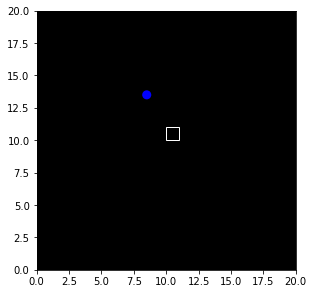

In [4]:
agent_params = {
        'load_model':   False,
        'load_dir':     '../data/outputs/gridworld/openfield{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'training_loc',
        'action_dims':  len(maze.actionlist),
        'lin_dims':     500,
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        'temperature':  1,
        'use_EC':       True,
        'cachelim':     300, # memory limit should be ~75% of #actions x #states
        'state_type':   'conv'
    }
run_dict = reset_agt(agent_params)
gp.plot_env(maze)


In [5]:
reload(expt)
run_dict = reset_agt(agent_params)
#expt.run_full_trials(run_dict, pen = -0.0)
expt.run_truncated_trials(run_dict, pen=-0.01, use_EC=True)

../memory/episodic.py:110: RuntimeWarning: overflow encountered in cosh
  return np.round(1 / np.cosh(p / envelope), 8)


[11:14:54]  Trial 1 TotRew = 0.95 (0.040s)
(12, 11) MF [0.16612755 0.17554983 0.16481832 0.16251603 0.1627795  0.16820873]
(12, 10) MF [0.1665996  0.1759234  0.16456074 0.16221528 0.16246092 0.16824003]
(12, 10) MF [0.1665996  0.1759234  0.16456074 0.16221528 0.16246092 0.16824003]
(12, 9) MF [0.16575521 0.17512117 0.1651481  0.16263445 0.16268337 0.16865775]
(12, 9) EC [0.16575521 0.17512117 0.1651481  0.16263445 0.16268337 0.16865775]
(12, 9) MF [0.16575521 0.17512117 0.1651481  0.16263445 0.16268337 0.16865775]
(12, 9) MF [0.16575521 0.17512117 0.1651481  0.16263445 0.16268337 0.16865775]
(12, 9) MF [0.16575521 0.17512117 0.1651481  0.16263445 0.16268337 0.16865775]
(13, 9) MF [0.16611657 0.17567074 0.16502365 0.16267455 0.16179812 0.16871634]
(13, 8) MF [0.16562971 0.17450732 0.16556333 0.16289434 0.16281575 0.16858953]
(13, 7) MF [0.16607982 0.17561957 0.16496105 0.16274573 0.16176666 0.16882722]
(13, 8) EC [0.16562971 0.17450732 0.16556333 0.16289434 0.16281575 0.16858953]
(13, 9

(18, 3) EC [0.1664891  0.17499521 0.1656787  0.16212256 0.16233255 0.16838184]
(18, 3) EC [0.1664891  0.17499521 0.1656787  0.16212256 0.16233255 0.16838184]
(18, 4) EC [0.1662066  0.17488855 0.16580735 0.16235726 0.16229443 0.16844586]
(18, 5) EC [0.16600747 0.17483707 0.16545814 0.16243619 0.16241156 0.16884956]
(17, 5) EC [0.16626222 0.17477073 0.16567615 0.162343   0.16223861 0.16870934]
(17, 5) EC [0.16626222 0.17477073 0.16567615 0.162343   0.16223861 0.16870934]
(16, 5) EC [0.16619107 0.17481188 0.16563402 0.16227584 0.16215655 0.16893056]
(16, 4) EC [0.16638215 0.17472343 0.16589601 0.16235958 0.16222943 0.16840944]
(15, 4) EC [0.16618994 0.17486033 0.16592307 0.16250376 0.16198441 0.16853844]
(15, 4) EC [0.16618994 0.17486033 0.16592307 0.16250376 0.16198441 0.16853844]
(15, 3) EC [0.16659799 0.17495644 0.16535677 0.16235475 0.16215155 0.16858245]
(15, 3) EC [0.16659799 0.17495644 0.16535677 0.16235475 0.16215155 0.16858245]
(15, 4) EC [0.16618994 0.17486033 0.16592307 0.16250

(14, 4) EC [0.16625816 0.17502311 0.1649173  0.1628911  0.16206537 0.16884494]
(14, 4) EC [0.16625816 0.17502311 0.1649173  0.1628911  0.16206537 0.16884494]
(14, 4) EC [0.16625816 0.17502311 0.1649173  0.1628911  0.16206537 0.16884494]
(13, 4) EC [0.16629721 0.1753164  0.1648262  0.16247262 0.16225062 0.16883703]
(13, 4) EC [0.16629721 0.1753164  0.1648262  0.16247262 0.16225062 0.16883703]
(13, 4) EC [0.16629721 0.1753164  0.1648262  0.16247262 0.16225062 0.16883703]
(13, 3) EC [0.16614446 0.17487012 0.16532616 0.16267985 0.16226768 0.16871163]
(14, 3) EC [0.16623956 0.17471908 0.16478647 0.16296047 0.16255862 0.1687358 ]
(14, 2) EC [0.16613986 0.1749566  0.16491237 0.1628159  0.16276443 0.16841082]
(13, 2) EC [0.16597056 0.1746169  0.16509236 0.1626942  0.16267607 0.16894989]
(13, 2) EC [0.16597056 0.1746169  0.16509236 0.1626942  0.16267607 0.16894989]
(13, 2) EC [0.16597056 0.1746169  0.16509236 0.1626942  0.16267607 0.16894989]
(12, 2) EC [0.16594945 0.1744073  0.16528544 0.16267

(2, 2) EC [0.16598113 0.17501996 0.16504236 0.16236597 0.1623859  0.16920467]
(2, 1) EC [0.16606258 0.17545798 0.16503744 0.16228391 0.16205223 0.16910592]
(3, 1) EC [0.16636361 0.17573884 0.16470894 0.16257152 0.16187707 0.1687401 ]
(3, 1) EC [0.16636361 0.17573884 0.16470894 0.16257152 0.16187707 0.1687401 ]
(4, 1) EC [0.16595483 0.175553   0.16497381 0.16260925 0.16225874 0.16865039]
(4, 0) EC [0.1661821  0.1754969  0.1648697  0.16298354 0.16200323 0.16846457]
(5, 0) EC [0.16579236 0.1755767  0.16499689 0.16301034 0.16220164 0.16842206]
(5, 0) EC [0.16579236 0.1755767  0.16499689 0.16301034 0.16220164 0.16842206]
(5, 0) EC [0.16579236 0.1755767  0.16499689 0.16301034 0.16220164 0.16842206]
(5, 0) EC [0.16579236 0.1755767  0.16499689 0.16301034 0.16220164 0.16842206]
(5, 0) EC [0.16579236 0.1755767  0.16499689 0.16301034 0.16220164 0.16842206]
(6, 0) EC [0.16579193 0.1752251  0.16539067 0.16293447 0.16223486 0.16842288]
(6, 0) EC [0.16579193 0.1752251  0.16539067 0.16293447 0.1622348

(11, 6) EC [0.16582605 0.17582223 0.16543452 0.16308059 0.16163296 0.1682037 ]
(11, 7) EC [0.16524264 0.17567165 0.16599874 0.16324502 0.16180706 0.1680349 ]
(12, 7) EC [0.16585794 0.17573154 0.16549686 0.16283922 0.16162007 0.16845445]
(11, 7) EC [0.16524264 0.17567165 0.16599874 0.16324502 0.16180706 0.1680349 ]
(10, 7) EC [0.16583875 0.17575976 0.16555364 0.16304821 0.16195238 0.16784732]
(10, 7) EC [0.16583875 0.17575976 0.16555364 0.16304821 0.16195238 0.16784732]
(10, 6) EC [0.16579427 0.17592146 0.16519774 0.16309884 0.16181725 0.16817039]
(10, 5) EC [0.16575493 0.17595418 0.16513382 0.16310367 0.16158888 0.16846447]
(9, 5) EC [0.16615006 0.1756854  0.16583765 0.16277245 0.16152601 0.16802837]
(9, 5) EC [0.16615006 0.1756854  0.16583765 0.16277245 0.16152601 0.16802837]
(9, 6) EC [0.16598901 0.1760478  0.16559637 0.16256826 0.16206639 0.1677322 ]
(9, 6) EC [0.16598901 0.1760478  0.16559637 0.16256826 0.16206639 0.1677322 ]
(10, 6) EC [0.16579427 0.17592146 0.16519774 0.16309884 

(7, 14) EC [0.16577543 0.1755274  0.16569698 0.16314319 0.16227297 0.16758406]
(7, 14) EC [0.16577543 0.1755274  0.16569698 0.16314319 0.16227297 0.16758406]
(6, 14) EC [0.16561145 0.17518388 0.16592309 0.16298233 0.16234632 0.16795288]
(6, 14) EC [0.16561145 0.17518388 0.16592309 0.16298233 0.16234632 0.16795288]
(6, 14) EC [0.16561145 0.17518388 0.16592309 0.16298233 0.16234632 0.16795288]
(7, 14) EC [0.16577543 0.1755274  0.16569698 0.16314319 0.16227297 0.16758406]
(7, 14) EC [0.16577543 0.1755274  0.16569698 0.16314319 0.16227297 0.16758406]
(7, 13) EC [0.16556594 0.1751698  0.16566339 0.16320121 0.1624513  0.1679483 ]
(7, 14) EC [0.16577543 0.1755274  0.16569698 0.16314319 0.16227297 0.16758406]
(7, 13) EC [0.16556594 0.1751698  0.16566339 0.16320121 0.1624513  0.1679483 ]
(7, 14) EC [0.16577543 0.1755274  0.16569698 0.16314319 0.16227297 0.16758406]
(7, 13) EC [0.16556594 0.1751698  0.16566339 0.16320121 0.1624513  0.1679483 ]
(7, 13) EC [0.16556594 0.1751698  0.16566339 0.16320

(0, 14) EC [0.16625455 0.17528518 0.1660482  0.162727   0.16118935 0.16849577]
(0, 15) EC [0.16591758 0.17495558 0.1658228  0.16314079 0.16108866 0.16907471]
(0, 15) EC [0.16591758 0.17495558 0.1658228  0.16314079 0.16108866 0.16907471]
(0, 15) EC [0.16591758 0.17495558 0.1658228  0.16314079 0.16108866 0.16907471]
(0, 14) EC [0.16625455 0.17528518 0.1660482  0.162727   0.16118935 0.16849577]
(0, 13) EC [0.16611113 0.17592436 0.16575508 0.16245823 0.16116646 0.16858484]
(0, 14) EC [0.16625455 0.17528518 0.1660482  0.162727   0.16118935 0.16849577]
(1, 14) EC [0.1658226  0.17482746 0.16632293 0.16286397 0.16108462 0.1690784 ]
(2, 14) EC [0.16585046 0.17456645 0.16674182 0.16275921 0.16142231 0.16865964]
(3, 14) EC [0.1653878  0.1747413  0.16685228 0.16282064 0.16136144 0.16883652]
(4, 14) EC [0.16562177 0.17499496 0.16658619 0.16308893 0.16166689 0.16804132]
(4, 14) EC [0.16562177 0.17499496 0.16658619 0.16308893 0.16166689 0.16804132]
(3, 14) EC [0.1653878  0.1747413  0.16685228 0.16282

KeyboardInterrupt: 

In [6]:
policy_loss = run_dict['total_loss'][0]
print(len(policy_loss))
value_loss = run_dict['total_loss'][1]
tot_reward = run_dict['total_reward']
trial_length = run_dict['trial_length']
#pick = [tot_reward, policy_loss, value_loss, trial_length]
#pickle.dump(pick, open("pickles/initial_training.p", "wb"))

2


In [7]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])

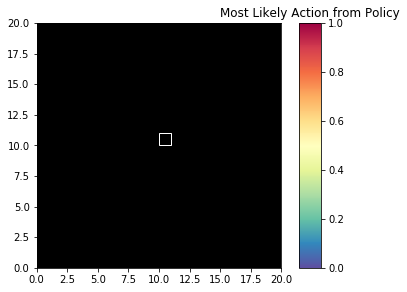

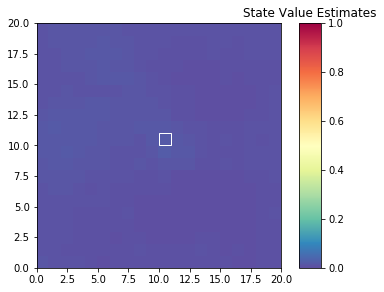

In [8]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])

gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range = [0,1])

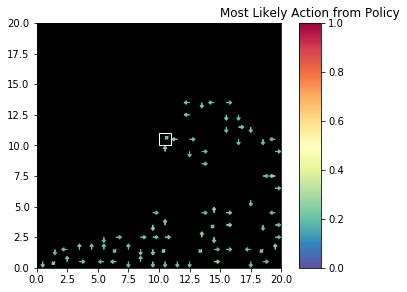

'\nfor i in range(len(agent_params[\'EC\'].cache_list)):\n    test_key = list(agent_params[\'EC\'].cache_list.keys())[i]\n    x = agent_params[\'EC\'].cache_list[test_key][2]\n    print("====\n",x)\n    if x==run_dict[\'environment\'].rwd_loc[0]:\n        agent_params[\'EC\'].recall_mem(test_key,1, decay=1000, prints=True)\n'

In [9]:
reload(gp)
ttt = ac.mem_snapshot(run_dict['environment'], agent_params['EC'], trial_timestamp=1, decay=1)
gp.plot_polmap(run_dict['environment'],ttt)

'''
for i in range(len(agent_params['EC'].cache_list)):
    test_key = list(agent_params['EC'].cache_list.keys())[i]
    x = agent_params['EC'].cache_list[test_key][2]
    print("====\n",x)
    if x==run_dict['environment'].rwd_loc[0]:
        agent_params['EC'].recall_mem(test_key,1, decay=1000, prints=True)
'''

In [ ]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

#ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
#ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

#plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [ ]:
x = -1
print(value_loss[x])
print(policy_loss[x])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
reload(gp)
gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range=[0,1.5])

In [11]:
def test_pvals(p, **kwargs):
    envelope = kwargs.get('envelope', 50)
    mfc      = kwargs.get('conf_score', 1)
    return mfc*np.round(1 / np.cosh(p / envelope), 8)

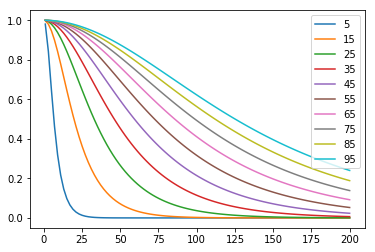

In [24]:

a = np.linspace(1,200, 100)#np.sort(np.random.randint(1,100,10))
b = 10*np.arange(10)+5
for i in b:
    a_p = test_pvals(a, envelope=i)
    plt.plot(a, a_p, '-', label=f'{i}')
plt.legend(loc=0)
#ax[1].plot(a_p)


In [ ]:
EC = agent_params['EC']

In [ ]:
import time
meas_time = time.time()
x = np.asarray(list(agent_params['EC'].cache_list.keys()))
#x = np.asarray([*agent_params['EC'].cache_list.keys()])
print(time.time() - meas_time)

In [ ]:
reload(ec)
test_case = x[0]+ 0.3*(np.random.randn(500))
key, index, sim = EC.cosine_sim(test_case)
print(key[0:10], index, sim)
EC.recall_mem(key, timestep=1)


In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])